# Approximation of ignition temperature and energy
This sheet calculates the ignition temperature of a gas mixture.
The calculation uses the [Le-Chatelier-Principal](https://en.wikipedia.org/wiki/Le_Chatelier%27s_principle) to estimate the mixtures ignition temperature:
$$
\frac{1}{T_z} = \sum \frac{z_i}{T_{zi}}
$$
The inert gas fraction is compensated via an effective temperature of 3000 K.

The minimum ignition energy is calculated with the same principal and is correct by $e^{3z_{inert}}$.
The sheet is an approximation and does not consider any molecule interaction. User is required to add enough safety margin or validate results against experimental measurements.
<div class="alert alert-block alert-danger">
This notebook is not validated.
</div>

### Author
&copy; Simon Bauer 2025

See `LICENSE`. 

## Packages

In [1]:
import math
import json
from pathlib import Path

import pandas as pd
from matplotlib import pyplot as plt
from chemicals import T_autoignition
from chemicals.identifiers import IDs_to_CASs

### Contribution
```
Caleb Bell, Yoel Rene Cortes-Pena, and Contributors (2016-2024). Chemicals: Chemical properties component of Chemical Engineering Design Library (ChEDL) https://github.com/CalebBell/chemicals.
````

## Functions

In [2]:
# function
def calculate_weighted_tz(zs, Tzs, effective_temperature = 3000):
    ws = 0
    for z,Tz in zip(zs, Tzs):
        if Tz is not None:
            ws += z / Tz
        else: # inert
            ws += z / effective_temperature # mean effective temperature. 
    return ws

def calculate_weighted_mie(zs, mies):
    ws = 0
    inert_z = 0
    for z,mie in zip(zs, mies):
        if mie is not None:
            ws += z / mie
        else: # inert
            inert_z += z
    return ws * math.exp(3*inert_z)

def normalize(zs, false_sum=None):
    false_sum = false_sum or math.fsum(zs)
    normalizer = 1 / false_sum
    return [val * normalizer for val in zs]

## Data Input
### Minimum Ignition Energy Data Base
Next we load from our database all available mies.
The table bases on several internet sources and [https://www.bgbau-medien.de/handlungshilfen_gb/daten/tr/trgs727/anhg.htm](https://www.bgbau-medien.de/handlungshilfen_gb/daten/tr/trgs727/anhg.htm). I recommend to check the used data in detail as they vary from source to source.

In [3]:
# load mie data
mie_db = json.loads(Path("./data/mie.json").read_text())
print(f"mie db contains {len(mie_db)} rows.")

mie db contains 165 rows.


### Gas data
For the demonstration gas data from [Stadtwerke Hameln Weserbergland](https://www.stwhw-netze.de/fileadmin/user_upload/Brennwerte_Gasanalyse_Hameln_2022.pdf) is used.
This gas data has rather low methane but high ethane concentration. Therefore,  I would qualify it as H-Gas Northsea.

In [4]:
gas_data_mole_percentages = {
    'nitrogen':.910,
    'methane':89.871,
    'carbon-dioxide':1.825,
    'ethane':6.177,
    'propane':0.996,
    'iso-butane':0.091,
    'n-butane':0.103,
    'neo-pentane':.0,
    'iso-pentane':.015,
    'n-pentane':.012,
    'hydrogen':.0,
}
zs = [val / 100 for val in gas_data_mole_percentages.values()]

## Prepare Data

In [5]:
# fetch required data
IDs = list(gas_data_mole_percentages)
CASRNs = IDs_to_CASs(IDs)
assert len(CASRNs) == len(gas_data_mole_percentages)
mies = [mie_db.get(cas, None) for cas in CASRNs]
Tzs = [T_autoignition(cas) for cas in CASRNs]
pd.DataFrame(
    [(ID, CASRN , mie, Tz) for CASRN, ID, mie, Tz in zip(CASRNs, IDs, mies, Tzs)],
    columns=["Name", "CAS", "MIE [mJ]", "Tz [K]"]
)


,Name,CAS,MIE [mJ],Tz [K]
0,nitrogen,7727-37-9,NaN,NaN
1,methane,74-82-8,0.300,873.15
2,carbon-dioxide,124-38-9,NaN,NaN
3,ethane,74-84-0,0.260,788.15
4,propane,74-98-6,0.260,723.15
5,iso-butane,75-28-5,0.250,733.15
6,n-butane,106-97-8,0.260,645.15
7,neo-pentane,463-82-1,1.570,723.15
8,iso-pentane,78-78-4,0.250,693.15
9,n-pentane,109-66-0,0.220,516.15


## Approximation

In [6]:
# Calculate ignition temperature of composition
Tzmin = 1 / calculate_weighted_tz(zs, Tzs, effective_temperature = 2500)
Tzmax = 1 / calculate_weighted_tz(zs, Tzs, effective_temperature = 3500)
mie = 1 / calculate_weighted_mie(zs, mies)
print("Ignition Temperature:")
print(f"Tzmin: {Tzmin-273.15:3.0f} °C")
print(f"Tzmax: {Tzmax-273.15:3.0f} °C")
print("\nMinimum Ignition Energy:")
print(f"MIE: {mie:.4f} mJ")

Ignition Temperature:
Tzmin: 607 °C
Tzmax: 610 °C

Minimum Ignition Energy:
MIE: 0.2808 mJ


### Calculate Variation of any component
The block below raises the concentration of one component.

In [7]:
# Change any component
component = "hydrogen"
component_idx = list(gas_data_mole_percentages).index(component)
print(f"Variate Component {component_idx} - {component}")
Tzsmixed = []
miesmixed = []
variated_zs = []
max_con = 100
component_concentration = list(range(0,max_con,1))
for c in component_concentration:
    z = c / 100
    zsc = [zo - zo*z for zo in zs]
    zsc[component_idx] = 1 - sum(zsc)
    variated_zs.append(zsc)
    Tzmixed = 1 / calculate_weighted_tz(zsc, Tzs, effective_temperature = 2500)
    miemixed = 1 / calculate_weighted_mie(zsc, mies)
    Tzsmixed.append(Tzmixed-273.15)
    miesmixed.append(miemixed)
pd.DataFrame(variated_zs, columns=gas_data_mole_percentages)

Variate Component 10 - hydrogen


,nitrogen,methane,carbon-dioxide,ethane,propane,iso-butane,n-butane,neo-pentane,iso-pentane,n-pentane,hydrogen
0,0.009100,0.898710,0.018250,0.061770,0.009960,0.000910,0.001030,0.0,0.000150,0.000120,1.110223e-16
1,0.009009,0.889723,0.018068,0.061152,0.009860,0.000901,0.001020,0.0,0.000148,0.000119,1.000000e-02
2,0.008918,0.880736,0.017885,0.060535,0.009761,0.000892,0.001009,0.0,0.000147,0.000118,2.000000e-02
3,0.008827,0.871749,0.017702,0.059917,0.009661,0.000883,0.000999,0.0,0.000145,0.000116,3.000000e-02
4,0.008736,0.862762,0.017520,0.059299,0.009562,0.000874,0.000989,0.0,0.000144,0.000115,4.000000e-02
...,...,...,...,...,...,...,...,...,...,...,...
95,0.000455,0.044936,0.000913,0.003089,0.000498,0.000046,0.000052,0.0,0.000007,0.000006,9.500000e-01
96,0.000364,0.035948,0.000730,0.002471,0.000398,0.000036,0.000041,0.0,0.000006,0.000005,9.600000e-01
97,0.000273,0.026961,0.000547,0.001853,0.000299,0.000027,0.000031,0.0,0.000005,0.000004,9.700000e-01
98,0.000182,0.017974,0.000365,0.001235,0.000199,0.000018,0.000021,0.0,0.000003,0.000002,9.800000e-01


<div class="alert alert-block alert-danger">
The explosion group and class depends on the local ATEX code realisation. The plot below shows the conservative energies limits I found. 
</div>

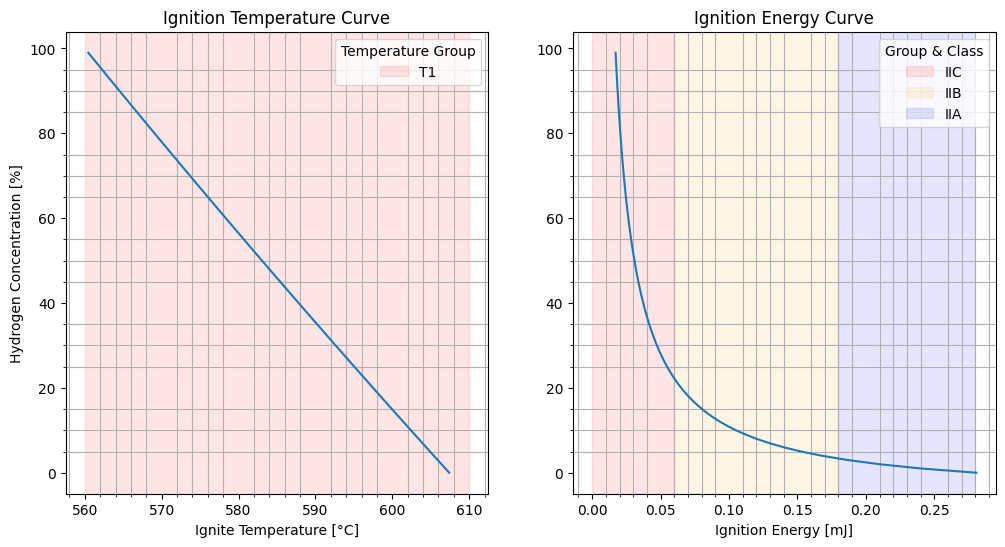

In [8]:
# plotting the results
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)

plt.plot(Tzsmixed, component_concentration)
plt.title("Ignition Temperature Curve")
plt.xlabel("Ignite Temperature [°C]")
plt.ylabel(f"{component.capitalize()} Concentration [%]")
EXT1 = plt.axvspan(560, 610, color='red', alpha=0.1, label="T1")
plt.legend(handles=[EXT1], title='Temperature Group')
plt.minorticks_on()
plt.grid(True, which='minor')

plt.subplot(1, 2, 2)
plt.plot(miesmixed, component_concentration)
IIC = plt.axvspan(0, .06, color='red', alpha=0.1, label="IIC")
IIB = plt.axvspan(.06, .18, color='orange', alpha=0.1, label="IIB")
IIA = plt.axvspan(.18, .28, color='blue', alpha=0.1, label="IIA")
plt.legend(handles=[IIC, IIB, IIA], title='Group & Class')

plt.title("Ignition Energy Curve")
plt.xlabel("Ignition Energy [mJ]")
plt.grid(True, which='minor')
plt.minorticks_on()